# Venice levels with TinyTimeMixer (TTM)

This notebook demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast up to 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-512-96 model or any new model available at the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Defines and Imports

### Imports

In [13]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# tsfm library
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters
)
from tsfm_public.toolkit.visualization import plot_predictions

### Important arguments

In [14]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Data loading, cleaning, manipulation, visualization, and saving tasks are performed in another notebook and saved in a github repository.
target_dataset = "venice"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_REVISION = "1024_96_v1"
TTM_INPUT_SEQ_LEN = 1024


## Helper functions

### Load and pre-process data

In [15]:
# Define data loaders using TSP from the tsfm library
def get_data(
    dataset_name: str,
    context_length,
    forecast_length,
    fewshot_fraction=1.0
):
    print(dataset_name, context_length, forecast_length)

    config_map = {
        "venice": {
            #"dataset_path": "https://raw.githubusercontent.com/matteorinalduzzi/TTM/main/datasets/venice/venice_small.csv",
            "dataset_path": "datasets/venice/venice_small.csv",
            "timestamp_column": "DATE",
            "id_columns": [],
            "target_columns": ["LEVEL"],
            "control_columns": ["PRESS"], 
            "split_config": {
                "train": 0.7,
                #"valid": 0.1,
                "test": 0.2,
            },
        },
    }
    if dataset_name not in config_map.keys():
        raise ValueError(
            f"Currently `get_data()` function supports the following datasets: {config_map.keys()}\n \
                         For other datasets, please provide the proper configs to the TimeSeriesPreprocessor (TSP) module."
        )

    dataset_path = config_map[dataset_name]["dataset_path"]
    timestamp_column = config_map[dataset_name]["timestamp_column"]
    id_columns = config_map[dataset_name]["id_columns"]
    target_columns = config_map[dataset_name]["target_columns"]
    split_config = config_map[dataset_name]["split_config"]
    control_columns = config_map[dataset_name]["control_columns"]


    if target_columns == []:
        df_tmp_ = pd.read_csv(dataset_path)
        target_columns = list(df_tmp_.columns)
        target_columns.remove(timestamp_column)

    data = pd.read_csv(
        dataset_path,
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": control_columns,
    
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
    )
    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

    return train_dataset, valid_dataset, test_dataset


### Zero-shot evaluation method definition

In [16]:
def zeroshot_eval(
    dataset_name, 
    batch_size,
    context_length=TTM_INPUT_SEQ_LEN,
    forecast_length=96,
    prediction_filter_length=None
):
    # Get data
    _, _, dset_test = get_data(dataset_name=dataset_name, 
                               context_length=context_length, 
                               forecast_length=forecast_length, 
                               fewshot_fraction=1.0
                              )
    
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size, 
            no_cuda=True # Necessary if you want to run the code without GPU (comment this line if you want to use cuda)
        )
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_predictions(model=zeroshot_trainer.model, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_zeroshot", channel=0)

### Few-shot finetune and evaluation method definition

In [17]:
def fewshot_finetune_eval(
        dataset_name, 
        batch_size, 
        learning_rate=0.001,
        context_length=TTM_INPUT_SEQ_LEN,
        forecast_length=96,
        fewshot_percent=5, 
        freeze_backbone=True,
        num_epochs=50,
        save_dir=OUT_DIR,
        prediction_filter_length=None
    ):
    
    out_dir = os.path.join(save_dir, dataset_name)
    
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)
    
    # Data prep: Get dataset
    dset_train, dset_val, dset_test = get_data(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100
    )


    if prediction_filter_length is None:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION,
        )
    elif prediction_filter_length <= forecast_length:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
        )
    else:
        raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        no_cuda=True # Necessary if you want to run the code without GPU (comment this line if you want to use cuda)
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_predictions(model=finetune_forecast_trainer.model, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_fewshot", channel=0)

## Run predictions on the dataset

### Zero-shot

venice 1024 96
Data lengths: train = 9575, val = 1434, test = 2960


/var/folders/bd/0ptjlsyj2rs1s_58grs1xtdh0000gn/T/ipykernel_21887/2068293641.py:66: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


/Users/mrinalduzzi/Desktop/Projects/TTM/.venv/lib/python3.10/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.3356313705444336, 'eval_runtime': 3.173, 'eval_samples_per_second': 932.864, 'eval_steps_per_second': 14.812}


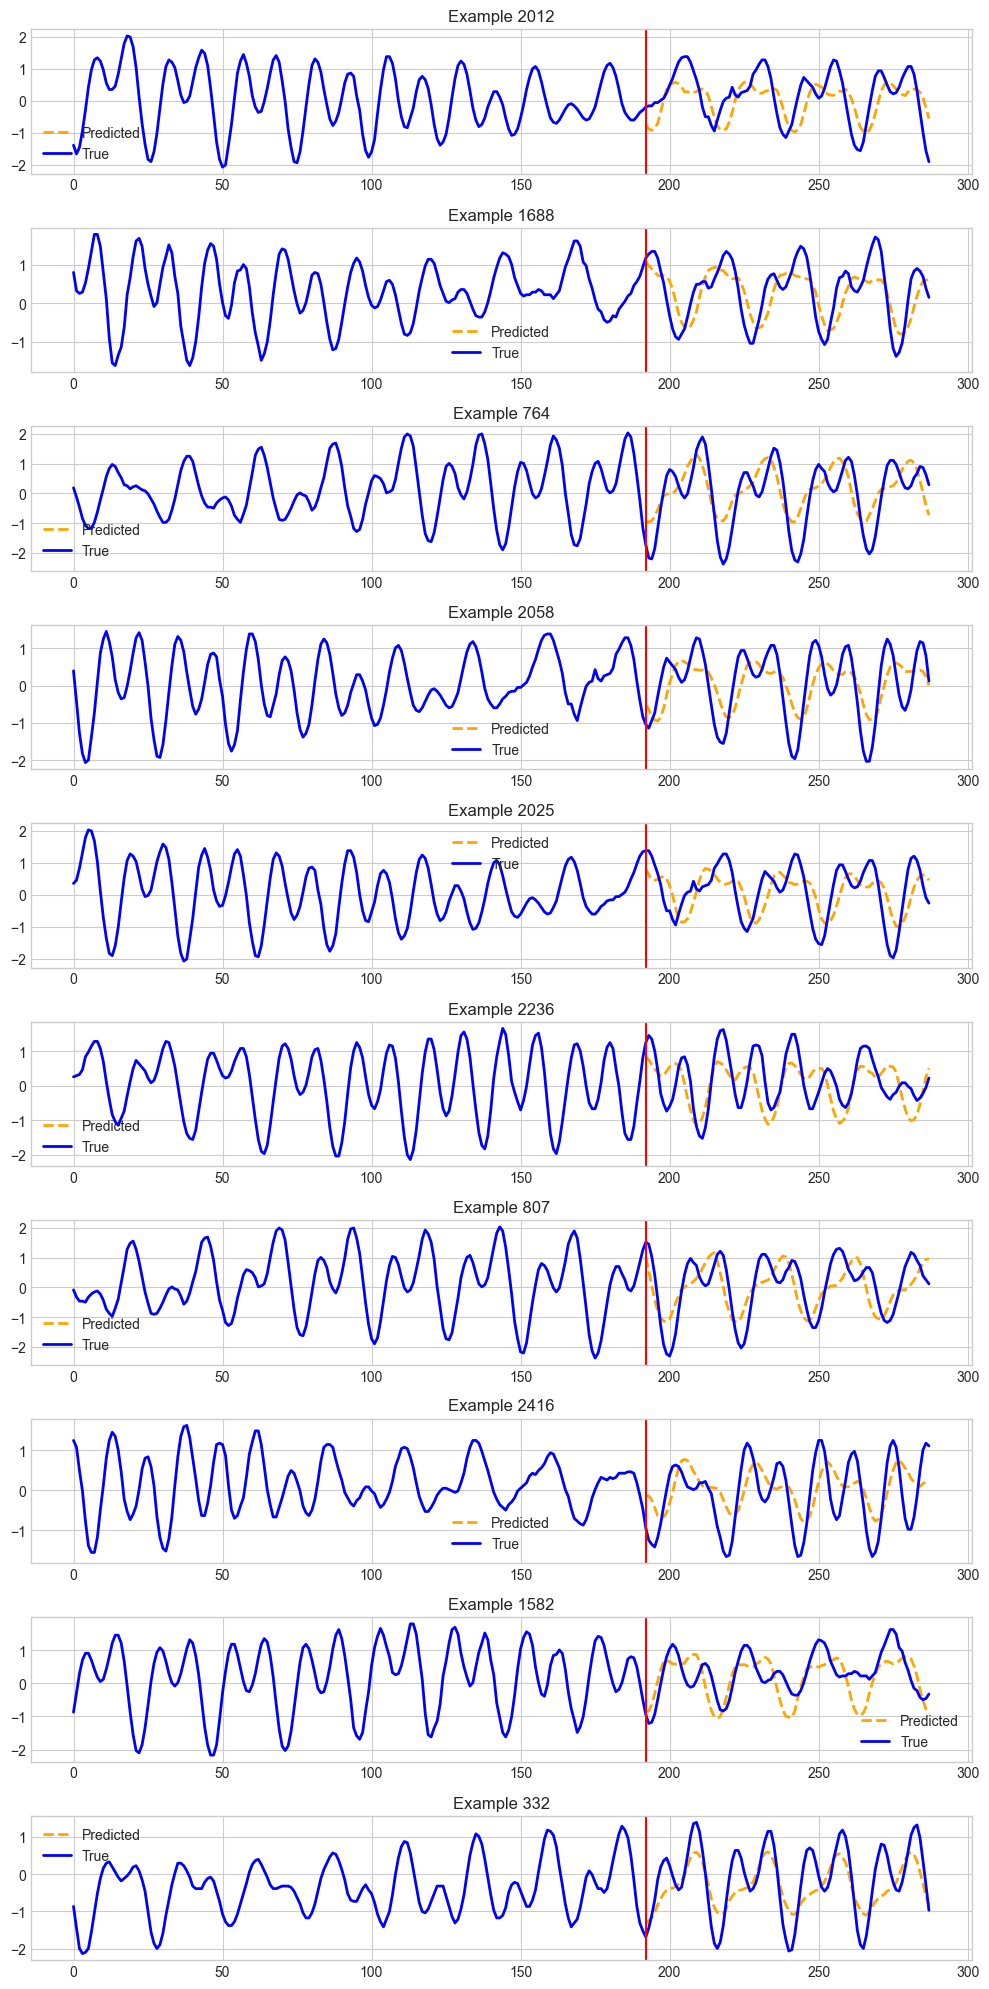

In [18]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
venice 1024 96
Data lengths: train = 388, val = 1434, test = 2960


/var/folders/bd/0ptjlsyj2rs1s_58grs1xtdh0000gn/T/ipykernel_21887/2068293641.py:66: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Number of params before freezing backbone 946336
Number of params after freezing the backbone 389984
Using learning rate = 0.001


/Users/mrinalduzzi/Desktop/Projects/TTM/.venv/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/mrinalduzzi/Desktop/Projects/TTM/.venv/lib/python3.10/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


  0%|          | 0/350 [00:00<?, ?it/s]

INFO:p-21961:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21964:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21968:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21975:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21976:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21977:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21978:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21979:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.8866, 'grad_norm': 1.7304736375808716, 'learning_rate': 5.069108014199347e-05, 'epoch': 1.0}


INFO:p-21994:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21996:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-21999:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22001:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22002:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22003:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22004:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22005:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.5429512858390808, 'eval_runtime': 58.8102, 'eval_samples_per_second': 24.384, 'eval_steps_per_second': 0.391, 'epoch': 1.0}


INFO:p-22032:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22033:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22042:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22043:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22044:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22045:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22046:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22047:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.8145, 'grad_norm': 1.7222243547439575, 'learning_rate': 8.228807392379669e-05, 'epoch': 2.0}


INFO:p-22061:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22062:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22069:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22070:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22079:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22080:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22081:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22085:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.5239222645759583, 'eval_runtime': 59.5682, 'eval_samples_per_second': 24.073, 'eval_steps_per_second': 0.386, 'epoch': 2.0}


INFO:p-22094:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22095:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22103:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22104:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22105:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22106:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22107:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22108:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.8077, 'grad_norm': 2.45229434967041, 'learning_rate': 0.0001333834563755459, 'epoch': 3.0}


INFO:p-22126:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22133:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22134:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22135:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22136:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22137:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22138:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22139:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.4962034821510315, 'eval_runtime': 58.7102, 'eval_samples_per_second': 24.425, 'eval_steps_per_second': 0.392, 'epoch': 3.0}


INFO:p-22152:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22153:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22158:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22159:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22160:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22161:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22162:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22163:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.7484, 'grad_norm': 1.5556631088256836, 'learning_rate': 0.00020170112404441828, 'epoch': 4.0}


INFO:p-22171:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22172:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22173:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22174:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22175:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22181:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22182:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22183:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.45869341492652893, 'eval_runtime': 57.5788, 'eval_samples_per_second': 24.905, 'eval_steps_per_second': 0.399, 'epoch': 4.0}


INFO:p-22196:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22197:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22205:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22206:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22207:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22208:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22209:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22210:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.6674, 'grad_norm': 1.6702120304107666, 'learning_rate': 0.00028419778667973885, 'epoch': 5.0}


INFO:p-22227:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22228:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22229:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22230:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22231:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22232:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22234:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22241:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.41017693281173706, 'eval_runtime': 58.4037, 'eval_samples_per_second': 24.553, 'eval_steps_per_second': 0.394, 'epoch': 5.0}


INFO:p-22421:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22422:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22430:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22431:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22432:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22433:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22434:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22435:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.4969, 'grad_norm': 1.4982048273086548, 'learning_rate': 0.00037719853414950255, 'epoch': 6.0}


INFO:p-22448:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22449:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22451:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22452:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22453:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22454:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22455:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22456:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3665355145931244, 'eval_runtime': 57.7415, 'eval_samples_per_second': 24.835, 'eval_steps_per_second': 0.398, 'epoch': 6.0}


INFO:p-22466:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22480:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22481:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22482:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22484:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22485:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22489:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22490:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.4398, 'grad_norm': 1.943901538848877, 'learning_rate': 0.00047656053960177386, 'epoch': 7.0}


INFO:p-22510:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22511:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22512:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22513:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22514:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22515:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22516:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22520:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.34401240944862366, 'eval_runtime': 58.5233, 'eval_samples_per_second': 24.503, 'eval_steps_per_second': 0.393, 'epoch': 7.0}


INFO:p-22531:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22540:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22541:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22542:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22543:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22544:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22545:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22547:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.3013, 'grad_norm': 1.4110103845596313, 'learning_rate': 0.000577857606522555, 'epoch': 8.0}


INFO:p-22575:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22576:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22578:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22579:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22580:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22581:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22582:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22583:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3442281484603882, 'eval_runtime': 58.2513, 'eval_samples_per_second': 24.617, 'eval_steps_per_second': 0.395, 'epoch': 8.0}


INFO:p-22603:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22604:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22605:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22606:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22607:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22609:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22611:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22612:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.2105, 'grad_norm': 1.0149062871932983, 'learning_rate': 0.0006765773388260172, 'epoch': 9.0}


INFO:p-22637:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22642:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22643:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22646:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22647:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22648:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22650:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22653:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3927162289619446, 'eval_runtime': 59.1742, 'eval_samples_per_second': 24.234, 'eval_steps_per_second': 0.389, 'epoch': 9.0}


INFO:p-22675:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22679:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22680:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22681:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22682:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22683:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22684:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22685:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.1733, 'grad_norm': 1.0682518482208252, 'learning_rate': 0.0007683221508052753, 'epoch': 10.0}


INFO:p-22705:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22706:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22707:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22708:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22709:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22710:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22714:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22715:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.406581848859787, 'eval_runtime': 59.9636, 'eval_samples_per_second': 23.915, 'eval_steps_per_second': 0.384, 'epoch': 10.0}


INFO:p-22735:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22742:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22743:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22744:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22745:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22746:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22747:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22748:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.1504, 'grad_norm': 1.150872826576233, 'learning_rate': 0.0008490051627208191, 'epoch': 11.0}


INFO:p-22770:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22777:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22778:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22779:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22780:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22781:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22782:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22783:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3969511091709137, 'eval_runtime': 57.7891, 'eval_samples_per_second': 24.814, 'eval_steps_per_second': 0.398, 'epoch': 11.0}


INFO:p-22794:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22807:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22808:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22809:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22810:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22812:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22813:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22814:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.1257, 'grad_norm': 0.6778002381324768, 'learning_rate': 0.000915032255628955, 'epoch': 12.0}


INFO:p-22825:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22832:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22833:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22834:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22835:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22839:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22840:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22841:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.4111248850822449, 'eval_runtime': 57.8692, 'eval_samples_per_second': 24.78, 'eval_steps_per_second': 0.397, 'epoch': 12.0}


INFO:p-22854:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22861:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22870:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22871:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22872:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22873:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22874:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22875:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.1142, 'grad_norm': 0.7342525720596313, 'learning_rate': 0.0009634621756054177, 'epoch': 13.0}


INFO:p-22955:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22963:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22964:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22965:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22966:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22967:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22972:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-22973:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.42371001839637756, 'eval_runtime': 58.4554, 'eval_samples_per_second': 24.532, 'eval_steps_per_second': 0.393, 'epoch': 13.0}


INFO:p-23005:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23019:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23021:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23022:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23023:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23026:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23027:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23028:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.0967, 'grad_norm': 0.7031217217445374, 'learning_rate': 0.000992137555334629, 'epoch': 14.0}


INFO:p-23044:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23046:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23048:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23049:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23050:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23052:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23053:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23054:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.436820924282074, 'eval_runtime': 58.0957, 'eval_samples_per_second': 24.683, 'eval_steps_per_second': 0.396, 'epoch': 14.0}


INFO:p-23089:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23090:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23096:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23097:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23098:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23099:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23100:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23101:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.0915, 'grad_norm': 0.7332638502120972, 'learning_rate': 0.0009999588945035823, 'epoch': 15.0}


INFO:p-23114:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23115:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23116:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23117:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23118:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23119:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23120:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23121:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.44081103801727295, 'eval_runtime': 57.5598, 'eval_samples_per_second': 24.913, 'eval_steps_per_second': 0.4, 'epoch': 15.0}


INFO:p-23133:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23134:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23142:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23143:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23144:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23145:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23146:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23147:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.0823, 'grad_norm': 0.6650650501251221, 'learning_rate': 0.0009973715183971973, 'epoch': 16.0}


INFO:p-23167:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23174:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23182:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23185:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23186:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23193:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23194:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23195:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.4566819667816162, 'eval_runtime': 57.8173, 'eval_samples_per_second': 24.802, 'eval_steps_per_second': 0.398, 'epoch': 16.0}


INFO:p-23206:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23213:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23221:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23222:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23223:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23224:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23225:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23226:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


{'loss': 0.0752, 'grad_norm': 0.6873958706855774, 'learning_rate': 0.0009907796153772188, 'epoch': 17.0}


INFO:p-23271:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23278:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23279:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23280:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23281:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23282:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23283:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23284:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.45096731185913086, 'eval_runtime': 57.7213, 'eval_samples_per_second': 24.844, 'eval_steps_per_second': 0.398, 'epoch': 17.0}
{'train_runtime': 1888.5484, 'train_samples_per_second': 10.272, 'train_steps_per_second': 0.185, 'train_loss': 0.3695606058385192, 'epoch': 17.0}
[TrackingCallback] Mean Epoch Time = 52.70053066926844 seconds, Total Train Time = 1888.5488500595093
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


INFO:p-23296:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23303:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23304:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23305:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23310:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23311:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23312:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.
INFO:p-23315:t-8493076288:config.py:<module>:PyTorch version 2.3.1 available.


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.18172535300254822, 'eval_runtime': 59.7688, 'eval_samples_per_second': 49.524, 'eval_steps_per_second': 0.786, 'epoch': 17.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


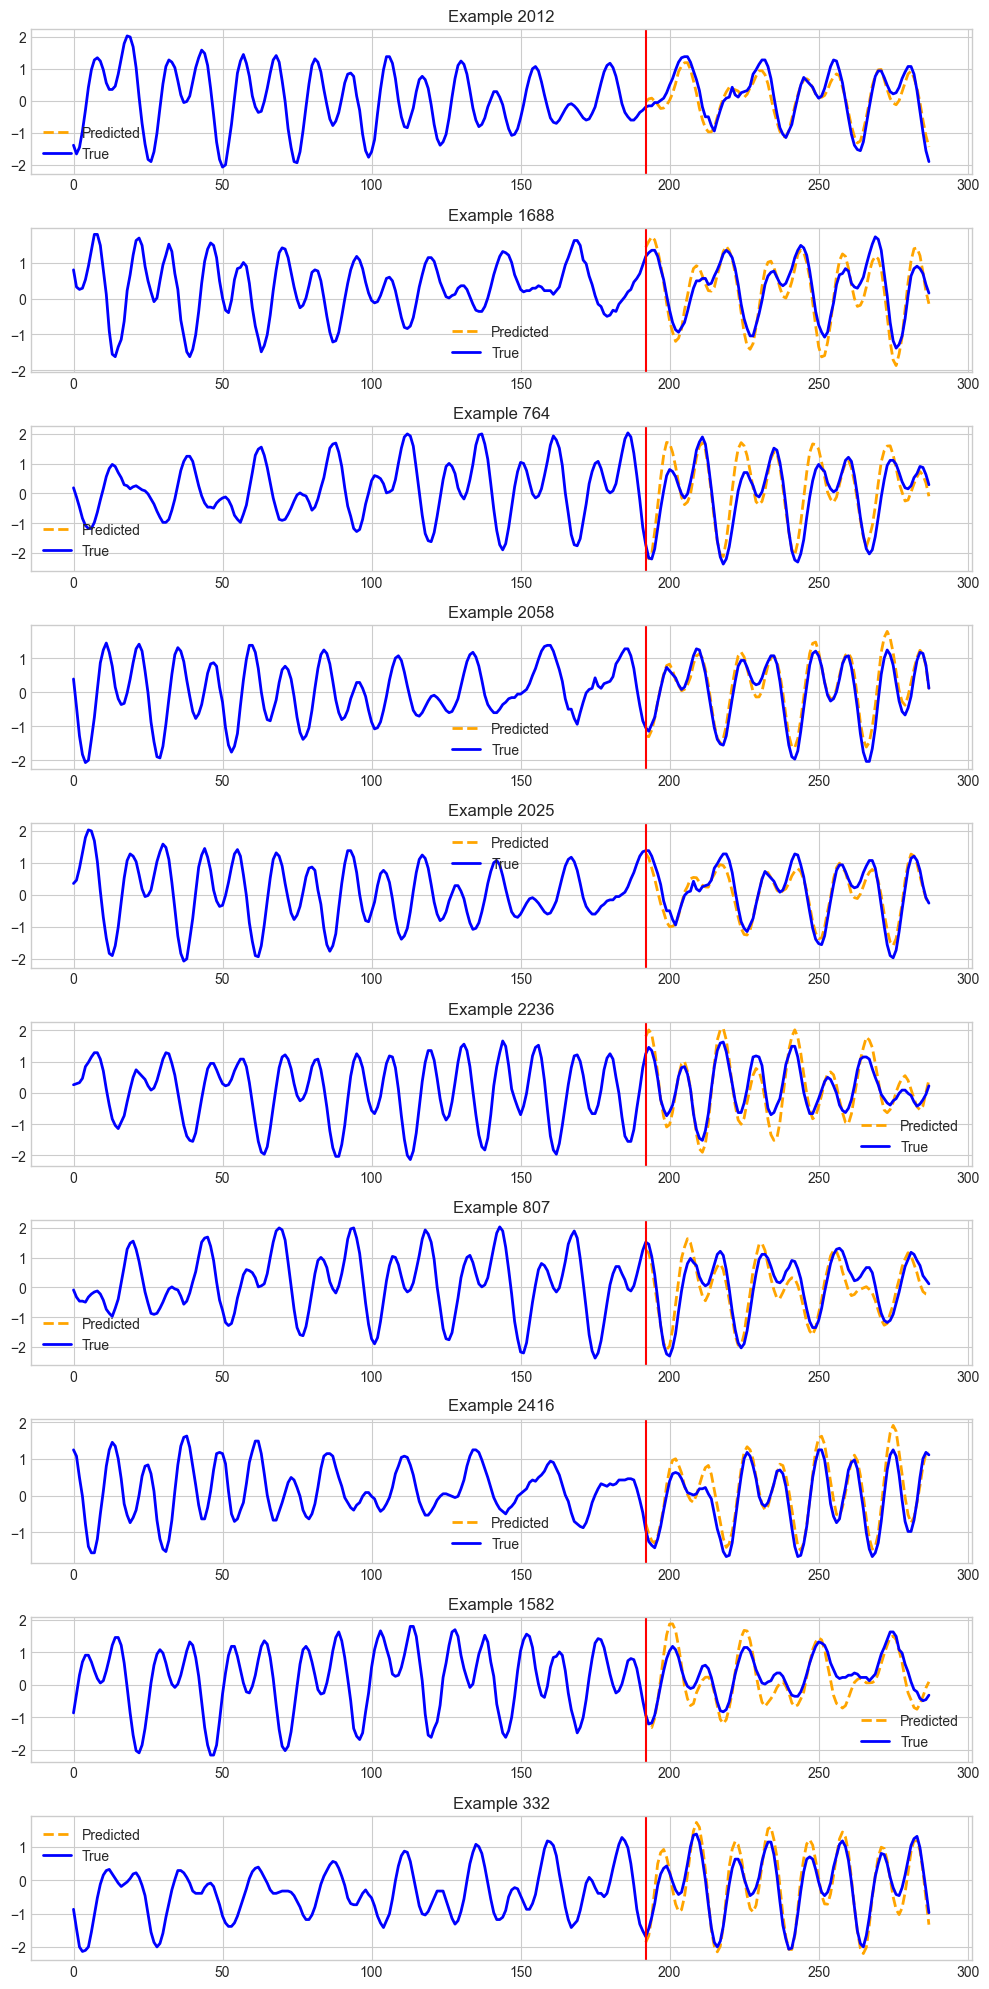

In [19]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)